In [1]:
%run helper.ipynb

In [2]:
TOPO_CONFIG_DIR = '../network-configs'
LATENCY_DATA_DIR = '../latency-data'
LATENCY_ANALYSIS_RESULT_DIR = '../latency-analysis/results'
GNN_RESULTS_DIR = '../gnn/results'
DATA_DIR = './data'
PLOT_DIR = './plots'

NUM_TOPOS = 100

CLEAN_RUN = False

SKIPPED_TOPOS = [33, 78, 79] + [3, 16, 29, 41, 62, 64, 95, 99]  # topos with no data + outlier topos
TOPOS_USED_FOR_TRAINING = [8, 31, 74, 53, 63, 22, 27, 58, 67, 28, 30, 77, 84, 47, 55, 14, 89, 76, 40, 38, 18, 45, 80, 93, 72, 7, 52, 98, 70, 51, 20, 44, 86, 91, 26, 54, 10, 23, 96, 59, 65, 75, 37, 32, 90, 56, 17, 60, 24, 88, 81, 46, 73, 39, 57, 19, 85, 42, 36, 6, 48, 43, 92, 82, 9, 35, 69, 71, 1, 97, 25]
TOPOS_USED_FOR_TESTING = [94, 21, 66, 68, 49, 87, 4, 2, 34, 50, 13, 11, 5, 83, 12, 0, 15, 61]

assert len(set(SKIPPED_TOPOS + TOPOS_USED_FOR_TRAINING + TOPOS_USED_FOR_TESTING)) == NUM_TOPOS

In [3]:
def save_plot(fig, filename):
    fig.savefig(os.path.join(PLOT_DIR, filename))

### Topology Config Helper Functions

In [4]:
topo_configs = {}
for i in range(NUM_TOPOS):
    with open(f'{TOPO_CONFIG_DIR}/nw-{i}.json') as f:
        topo_configs[i] = json.load(f)

def get_network_size(topo_num):
    return len(topo_configs[topo_num]['server'])

def get_num_flows(topo_num):
    return len(topo_configs[topo_num]['flow'])

def get_flow_length(topo_num, flow_num):
    return len(topo_configs[topo_num]['flow'][flow_num]['hops'])

def get_flow_rate(topo_num, flow_num):
    return topo_configs[topo_num]['flow'][flow_num]['rate'] / 1e3  # in Mbit/s

def get_link_util(topo_num, link_start, link_stop):
    link_rate = None
    for l in topo_configs[topo_num]['link']:
        if l['start'] == link_start and l['stop'] == link_stop:
            link_rate = l['capacity'] * 1000
            break
    assert link_rate is not None, f'link from {link_start} to {link_stop} not found!'

    sum_flow_rates = 0
    for f in topo_configs[topo_num]['flow']:
        for i in range(len(f['hops'])-1):
            if f['hops'][i] == link_start and f['hops'][i+1] == link_stop:
                sum_flow_rates += f['rate']
                break  # links are not traversed multiple times per flow

    return sum_flow_rates / link_rate

def get_max_link_util(topo_num, flow_num):
    f = topo_configs[topo_num]['flow'][flow_num]
    path_link_utils = []
    for i in range(len(f['hops'])-1):
        path_link_utils.append(get_link_util(topo_num, f['hops'][i], f['hops'][i+1]))
    return max(path_link_utils)

In [5]:
#for topo_num in [0, 4]:
#    print(f'topo {topo_num} - num_flows: {get_num_flows(topo_num)}, net_size: {get_network_size(topo_num)}')
#    for flow_num in range(get_num_flows(topo_num)):
#        print(f'\tflow {flow_num:02d}: flow_len: {get_flow_length(topo_num, flow_num)}, flow_rate: {get_flow_rate(topo_num, flow_num):5.1f}, max_link_util: {get_max_link_util(topo_num, flow_num):.2f}')

In [6]:
def analyze_topo_metric(get_func, name, print_output=True):
    l = []
    l_train = []
    l_test = []
    for i in range(NUM_TOPOS):
        if i in SKIPPED_TOPOS:
            continue
        metric_val = get_func(i)
        l.append(metric_val)
        if i in TOPOS_USED_FOR_TRAINING:
            l_train.append(metric_val)
        elif i in TOPOS_USED_FOR_TESTING:
            l_test.append(metric_val)

    if print_output:
        print(f'min. {name}: {min(l)}')
        print(f'max. {name}: {max(l)}')
        print(f'min. {name} (train): {min(l_train)}')
        print(f'max. {name} (train): {max(l_train)}')
        print(f'min. {name} (test): {min(l_test)}')
        print(f'max. {name} (test): {max(l_test)}')

    return l, l_train, l_test

def analyze_flow_metric(get_func, name, print_output=True):
    l = []
    l_train = []
    l_test = []
    for i in range(NUM_TOPOS):
        if i in SKIPPED_TOPOS:
            continue
        for j in range(get_num_flows(i)):
            metric_val = get_func(i, j)
            l.append(metric_val)
            if i in TOPOS_USED_FOR_TRAINING:
                l_train.append(metric_val)
            elif i in TOPOS_USED_FOR_TESTING:
                l_test.append(metric_val)

    if print_output:
        print(f'min. {name}: {min(l)}')
        print(f'max. {name}: {max(l)}')
        print(f'min. {name} (train): {min(l_train)}')
        print(f'max. {name} (train): {max(l_train)}')
        print(f'min. {name} (test): {min(l_test)}')
        print(f'max. {name} (test): {max(l_test)}')

    return l, l_train, l_test

# Network Size
analyze_topo_metric(get_network_size, 'network size')

# Number of Flows
analyze_topo_metric(get_num_flows, '#flows')

# Flow Length
analyze_flow_metric(get_flow_length, 'flow length')

# Flow Rate
flow_rates, flow_rates_train, flow_rates_test = analyze_flow_metric(get_flow_rate, '', False)

print(f'min. flow rate: {min(flow_rates):7.3f} Mbit/s')
print(f'max. flow rate: {max(flow_rates):7.3f} Mbit/s')
print(f'min. flow rate (train): {min(flow_rates_train):7.3f} Mbit/s')
print(f'max. flow rate (train): {max(flow_rates_train):7.3f} Mbit/s')
print(f'min. flow rate (test): {min(flow_rates_test):7.3f} Mbit/s')
print(f'max. flow rate (test): {max(flow_rates_test):7.3f} Mbit/s')

# Max. Link Utilization
max_link_utils, max_link_utils_train, max_link_utils_test = analyze_flow_metric(get_max_link_util, '', False)

print(f'min. max. link util.: {min(max_link_utils)*100:6.3f} %')
print(f'max. max. link util.: {max(max_link_utils)*100:6.3f} %')
print(f'min. max. link util. (train): {min(max_link_utils_train)*100:6.3f} %')
print(f'max. max. link util. (train): {max(max_link_utils_train)*100:6.3f} %')
print(f'min. max. link util. (test): {min(max_link_utils_test)*100:6.3f} %')
print(f'max. max. link util. (test): {max(max_link_utils_test)*100:6.3f} %')

# Total number of flows (in total, during training, during testing)
num_flows_total = 0
num_flows_train = 0
num_flows_test = 0
for i in range(NUM_TOPOS):
    if i in SKIPPED_TOPOS:
        continue
    if i in TOPOS_USED_FOR_TRAINING:
        num_flows_train += get_num_flows(i)
    elif i in TOPOS_USED_FOR_TESTING:
        num_flows_test += get_num_flows(i)
    num_flows_total += get_num_flows(i)
print(f'total #flows (train/test): {num_flows_total} ({num_flows_train}/{num_flows_test})')

min. network size: 8
max. network size: 15
min. network size (train): 8
max. network size (train): 15
min. network size (test): 9
max. network size (test): 15
min. #flows: 19
max. #flows: 59
min. #flows (train): 19
max. #flows (train): 59
min. #flows (test): 20
max. #flows (test): 54
min. flow length: 2
max. flow length: 9
min. flow length (train): 2
max. flow length (train): 9
min. flow length (test): 2
max. flow length (test): 9
min. flow rate:   1.000 Mbit/s
max. flow rate: 831.162 Mbit/s
min. flow rate (train):   1.000 Mbit/s
max. flow rate (train): 670.547 Mbit/s
min. flow rate (test):   1.000 Mbit/s
max. flow rate (test): 831.162 Mbit/s
min. max. link util.:  0.110 %
max. max. link util.: 86.526 %
min. max. link util. (train):  0.110 %
max. max. link util. (train): 86.526 %
min. max. link util. (test):  0.130 %
max. max. link util. (test): 84.967 %
total #flows (train/test): 3191 (2506/685)


### Dataset Latency HDR Plots

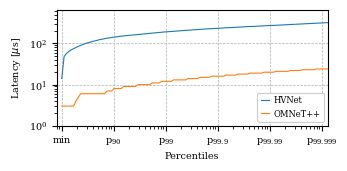

In [7]:
TOPO_NUM = 0

def load_hdr_data(topo_num, data_type):
    kwargs_load_hgmr = {
        'comment': '#',
        'skip_blank_lines': True,
        'sep': r"\s+",
        'engine': 'python',
        'header': 0,
        'names': ['Latency', 'Percentile'],
        'usecols': [0, 3]
    }
    filepath = os.path.join(DATA_DIR, f'{topo_num:02d}-hdr-data-{data_type}.hgrm')
    if not os.path.isfile(filepath):
        return None
    df = pd.read_csv(filepath, **kwargs_load_hgmr)
    return df

def calc_hdr_data(topo_num, data_type):
    infile_latencies = os.path.join(LATENCY_DATA_DIR, data_type,
                                    f'{topo_num:02d}-latencies-{data_type}-preprocessed.csv')
    outfile = os.path.join(DATA_DIR, f'{topo_num:02d}-hdr-data-{data_type}.hgrm')

    histogram = HdrHistogram(1, 20000, 2)
    with open(infile_latencies, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # skip header row
        for row in reader:
            histogram.record_value(float(row[0]))
            #print(histogram.get_total_count())
        with open(outfile, 'wb+') as g:
            histogram.output_percentile_distribution(g, 1)

    df = load_hdr_data(topo_num, data_type)
    return df

hgrm_df_hvnet = load_hdr_data(TOPO_NUM, 'hvnet')
if CLEAN_RUN or hgrm_df_hvnet is None:
    hgrm_df_hvnet = calc_hdr_data(TOPO_NUM, 'hvnet')

hgrm_df_omnet = load_hdr_data(TOPO_NUM, 'omnet')
if CLEAN_RUN or hgrm_df_omnet is None:
    hgrm_df_omnet = calc_hdr_data(TOPO_NUM, 'omnet')

fig, ax = plt.subplots()

sns.lineplot(x='Percentile', y='Latency', data=hgrm_df_hvnet, ax=ax, lw=.8, label='HVNet')
sns.lineplot(x='Percentile', y='Latency', data=hgrm_df_omnet, ax=ax, lw=.8, label='OMNeT++')

ax.set_xlabel('Percentiles')
ax.set_ylabel('Latency [$\mu$s]')
ax.set_xscale('log')
ax.set_yscale('log')

xticklabels = [
    'min',
    '$\mathregular{p_{90}}$',
    '$\mathregular{p_{99}}$',
    '$\mathregular{p_{99.9}}$',
    '$\mathregular{p_{99.99}}$',
    '$\mathregular{p_{99.999}}$'
]

ax.set_xticks([1, 1e1, 1e2, 1e3, 1e4, 1e5])
ax.set_xticklabels(xticklabels, rotation=0, ha='center')

ax.set_xlim(0.8, 130000)
ax.set_ylim(ymin=1)

plt.legend()

fig.set_size_inches(set_size('single')[0], set_size('single')[1] * .8)
fig.tight_layout()

save_plot(fig, 'hdr.pdf')

### Correlation HVNet vs. OMNeT++

    min: 0.874 (Q1: 0.933, Q2: 0.972, Q3: 0.982)
    p25: 0.737 (Q1: 0.625, Q2: 0.871, Q3: 0.945)
    p50: 0.723 (Q1: 0.614, Q2: 0.833, Q3: 0.923)
    p75: 0.720 (Q1: 0.544, Q2: 0.819, Q3: 0.891)
    p95: 0.648 (Q1: 0.444, Q2: 0.737, Q3: 0.864)
    p99: 0.596 (Q1: 0.386, Q2: 0.673, Q3: 0.821)
  p99.9: 0.543 (Q1: 0.316, Q2: 0.590, Q3: 0.784)
 p99.99: 0.468 (Q1: 0.238, Q2: 0.481, Q3: 0.696)
p99.999: 0.393 (Q1: 0.156, Q2: 0.383, Q3: 0.632)


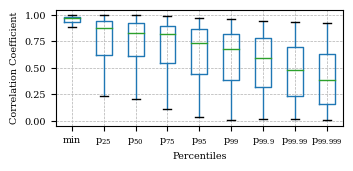

In [8]:
df_corrcoefs = pd.read_csv(os.path.join(LATENCY_ANALYSIS_RESULT_DIR, 'latency-corrcoefs.csv'))

columns_to_plot = {
    'min': 'min',
    'p25': '$\mathregular{p_{25}}$',
    'p50': '$\mathregular{p_{50}}$',
    'p75': '$\mathregular{p_{75}}$',
    'p95': '$\mathregular{p_{95}}$',
    'p99': '$\mathregular{p_{99}}$',
    'p99.9': '$\mathregular{p_{99.9}}$',
    'p99.99': '$\mathregular{p_{99.99}}$',
    'p99.999': '$\mathregular{p_{99.999}}$'
}

for column in list(columns_to_plot.keys()):
    data = df_corrcoefs[column]
    print(f"{column:>7}: {data.mean():.3f} (Q1: {data.quantile(.25):.3f}, Q2: {data.median():.3f}, Q3: {data.quantile(.75):.3f})")

fig, ax = plt.subplots()

df_corrcoefs.boxplot(column=list(columns_to_plot.keys()), sym='')

ax.set_xlabel('Percentiles')
ax.set_ylabel('Correlation Coefficient')
ax.set_xticklabels(list(columns_to_plot.values()), rotation=0, ha='center')

fig.set_size_inches(set_size('single')[0], set_size('single')[1] * .8)
fig.tight_layout()

save_plot(fig, 'corrcoefs_hvnet_omnet_flows.pdf')

### MAPE for Different Percentiles

    min: 0.127 (Q1: 0.043, Q2: 0.101, Q3: 0.186, max.: 0.629)
    p25: 0.244 (Q1: 0.087, Q2: 0.182, Q3: 0.316, max.: 1.120)
    p50: 0.266 (Q1: 0.092, Q2: 0.208, Q3: 0.342, max.: 0.959)
    p75: 0.290 (Q1: 0.103, Q2: 0.216, Q3: 0.379, max.: 1.025)
    p95: 0.303 (Q1: 0.115, Q2: 0.219, Q3: 0.414, max.: 1.296)
    p99: 0.304 (Q1: 0.104, Q2: 0.218, Q3: 0.422, max.: 1.139)
  p99.9: 0.295 (Q1: 0.102, Q2: 0.208, Q3: 0.405, max.: 1.030)
 p99.99: 0.289 (Q1: 0.097, Q2: 0.210, Q3: 0.400, max.: 1.015)
p99.999: 0.325 (Q1: 0.123, Q2: 0.250, Q3: 0.459, max.: 1.339)


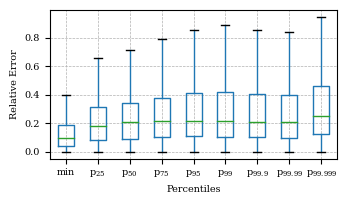

In [9]:
df_rel_errs = pd.read_csv(os.path.join(GNN_RESULTS_DIR, 'rel_errs.csv'))

percentiles_to_plot = {
    'min': 'min',
    'p25': '$\mathregular{p_{25}}$',
    'p50': '$\mathregular{p_{50}}$',
    'p75': '$\mathregular{p_{75}}$',
    'p95': '$\mathregular{p_{95}}$',
    'p99': '$\mathregular{p_{99}}$',
    'p99.9': '$\mathregular{p_{99.9}}$',
    'p99.99': '$\mathregular{p_{99.99}}$',
    'p99.999': '$\mathregular{p_{99.999}}$'
}

for target in list(percentiles_to_plot.keys()):
    data = df_rel_errs[df_rel_errs['target'] == target]['rel_err']
    print(f"{target:>7}: {data.mean():.3f} (Q1: {data.quantile(.25):.3f}, Q2: {data.median():.3f}, Q3: {data.quantile(.75):.3f}, max.: {data.max():.3f})")

fig, ax = plt.subplots()

df_rel_errs_filtered = df_rel_errs[df_rel_errs['target'].isin(list(percentiles_to_plot.keys()))]
plot = df_rel_errs_filtered.boxplot(column='rel_err', by='target', sym='', ax=ax)

ax.set_title('')
ax.set_xlabel('Percentiles')
ax.set_ylabel('Relative Error')
ax.set_xticklabels(list(columns_to_plot.values()), rotation=0, ha='center')

fig.suptitle('')

fig.set_size_inches(set_size('single'))
fig.tight_layout()

save_plot(fig, 'rel_err_percentiles.pdf')

### MAPE for Different Topologies

In [10]:
df_rel_errs = pd.read_csv(os.path.join(GNN_RESULTS_DIR, 'rel_errs.csv'))

df_rel_errs.groupby(by='topo_num')['rel_err'].mean()

topo_num
0     0.136412
2     0.268894
4     0.479304
5     0.166377
11    0.127621
12    0.472779
13    0.135894
15    0.232585
21    0.233619
34    0.640410
49    0.146218
50    0.306329
61    0.408704
66    0.454755
68    0.171093
83    0.185276
87    0.179164
94    0.307415
Name: rel_err, dtype: float64

### Effect of Different Properties on Relative Error

overall MAPE: 27.163 %
=== flow_rate ===
    min: (1.01, 0.147) (6.96, 0.106) (20.78, 0.070) (39.86, 0.085) (66.00, 0.115) (139.58, 0.096) (340.50, 0.131) 
    p50: (1.01, 0.306) (6.96, 0.245) (20.78, 0.176) (39.86, 0.168) (66.00, 0.239) (139.58, 0.207) (340.50, 0.236) 
p99.999: (1.01, 0.372) (6.96, 0.208) (20.78, 0.266) (39.86, 0.285) (66.00, 0.268) (139.58, 0.271) (340.50, 0.269) 

=== max_link_util ===
    min: (0.03, 0.126) (0.16, 0.087) (0.30, 0.109) (0.41, 0.086) (0.53, 0.161) (0.69, 0.195) 
    p50: (0.03, 0.219) (0.16, 0.303) (0.30, 0.269) (0.41, 0.247) (0.53, 0.219) (0.69, 0.341) 
p99.999: (0.03, 0.190) (0.16, 0.373) (0.30, 0.380) (0.41, 0.340) (0.53, 0.283) (0.69, 0.386) 



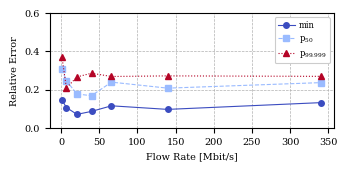

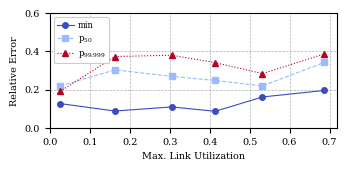

In [11]:
df_rel_errs = pd.read_csv(os.path.join(GNN_RESULTS_DIR, 'rel_errs.csv'))

print(f"overall MAPE: {df_rel_errs['rel_err'].mean() * 100:.3f} %")

row_to_net_size = lambda row: get_network_size(row['topo_num'])
row_to_num_flows = lambda row: get_num_flows(row['topo_num'])
row_to_flow_len = lambda row: get_flow_length(row['topo_num'], row['flow_num'])
row_to_flow_rate = lambda row: get_flow_rate(row['topo_num'], row['flow_num'])
row_to_max_link_util = lambda row: get_max_link_util(row['topo_num'], row['flow_num'])
df_rel_errs['net_size'] = df_rel_errs.apply(row_to_net_size, axis=1)
df_rel_errs['num_flows'] = df_rel_errs.apply(row_to_num_flows, axis=1)
df_rel_errs['flow_len'] = df_rel_errs.apply(row_to_flow_len, axis=1)
df_rel_errs['flow_rate'] = df_rel_errs.apply(row_to_flow_rate, axis=1)
df_rel_errs['max_link_util'] = df_rel_errs.apply(row_to_max_link_util, axis=1)

property_names = {
    'net_size': 'Network Size',
    'num_flows': 'Number of Flows',
    'flow_len': 'Flow Length',
    'flow_rate': 'Flow Rate [Mbit/s]',
    'max_link_util': 'Max. Link Utilization'
}

target_names = {
    'min': 'min',
    'p25': '$\\mathregular{p_{25}}$',
    'p50': '$\\mathregular{p_{50}}$',
    'p75': '$\\mathregular{p_{75}}$',
    'p99': '$\\mathregular{p_{99}}$',
    'p99.9': '$\\mathregular{p_{99.9}}$',
    'p99.99': '$\\mathregular{p_{99.99}}$',
    'p99.999': '$\\mathregular{p_{99.999}}$'
}

target_indices = {
    'min': 0,
    'p25': 1,
    'p50': 2,
    'p75': 3,
    'p99': 4,
    'p99.9': 5,
    'p99.99': 6,
    'p99.999': 7
}

targets_to_plot = [
    'min',
    #'p25',
    'p50',
    #'p75',
    #'p99',
    'p99.999'
]

colors = cm.coolwarm(np.linspace(0, 1, len(target_names)))
linestyles = ['-', '--', ':', '-.', (0, (3, 5, 1, 5, 1, 5)), (0, (5, 10))]
markers = ['o', 's', '^', 'D', '*', 'h']


def plot_rel_error_by_prop(df_errs, prop, targets_to_plot, num_bins=None, xlim=(0, None), ylim=(0,.8)):
    print(f'=== {prop} ===')

    fig, ax = plt.subplots()

    i = 0
    for label, df in df_errs.groupby(by='target'):
        if label in targets_to_plot:
            #sns.lineplot(data=df[df.target == label], x=prop, y='rel_err', hue='target')
            plot_data_q1 = None
            plot_data_q3 = None
            if num_bins is not None:
                df_grouped = df.groupby(by=pd.qcut(df[prop], num_bins, duplicates='drop'))
                plot_data = df_grouped.mean(numeric_only=True)
                #plot_data_q1 = df_grouped.quantile(.25, numeric_only=True)
                #plot_data_q3 = df_grouped.quantile(.75, numeric_only=True)
                #print(df_grouped.count())
                #print(plot_data.reset_index(names=[f'{prop}_range'])[f'{prop}_range'].iloc[0].left)
            else:
                plot_data = df.groupby(by=prop).mean(numeric_only=True).reset_index()
            c = colors[target_indices[label]]
            plot_data.plot(
                x=prop, y='rel_err', ax=ax, label=target_names[label],
                color=c, lw=.8, linestyle=linestyles[i], marker=markers[i], markersize=4
            )
            if plot_data_q1 is not None and plot_data_q3 is not None:
                plt.fill_between(plot_data[prop], plot_data_q1['rel_err'], plot_data_q3['rel_err'], alpha=.09, color=c)
            print(f'{label:>7}: ', end='')
            for err_idx, err in enumerate(plot_data['rel_err']):
                print(f"({plot_data[prop].iloc[err_idx]:.2f}, {err:.3f}) ", end='')
            print()
            i += 1

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_xlabel(property_names[prop])
    ax.set_ylabel('Relative Error')

    ax.legend(handlelength=2)

    fig.set_size_inches(set_size('single')[0], set_size('single')[1] * .8)
    fig.tight_layout()

    save_plot(fig, f'rel_err_{prop}.pdf')
    
    print()


#for prop in ['net_size', 'num_flows', 'flow_len']:
#    plot_rel_error_by_prop(df_rel_errs, prop, targets_to_plot)

#flow_rate_bins = pd.IntervalIndex.from_breaks([0, 100, 200, 400, 900])
plot_rel_error_by_prop(df_rel_errs, 'flow_rate', targets_to_plot, 14, xlim=(-15, None), ylim=(0, .6))

#max_link_util_bins = pd.IntervalIndex.from_breaks([0, .2, .4, .6, .8, 1])
plot_rel_error_by_prop(df_rel_errs, 'max_link_util', targets_to_plot, 6, ylim=(0, .6))

In [12]:
def plot_rel_err_boxplot(df_errs, prop, target, num_bins=None):
    fig, ax = plt.subplots()
    if num_bins is not None:
        plot_data = df_errs[df_errs['target'] == target].groupby(by=pd.cut(df_errs[prop], num_bins)).mean(numeric_only=True)
    else:
        plot_data = df_errs[df_errs['target'] == target]
    print(plot_data)
    plot_data.boxplot(x=prop, y='rel_err', ax=ax, label=target)

#plot_rel_err_boxplot(df_rel_errs, 'net_size', 'min', num_bins=None)

#df_rel_errs[df_rel_errs['target'] == 'min'].boxplot(column='rel_err', by='flow_rate')


### Feature Importance

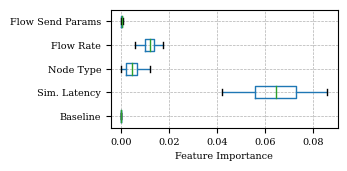

In [13]:
df_feat_imp = pd.read_csv(os.path.join(GNN_RESULTS_DIR, 'feature_importance.csv'))

df_feat_imp = df_feat_imp - df_feat_imp['baseline'][0]
df_feat_imp = df_feat_imp.abs()
features_to_compare = {
    'baseline': 'Baseline',
    'flow_latency_percentiles_omnet': 'Sim. Latency',
    'ntype': 'Node Type',
    'flow_rate': 'Flow Rate',
    'flow_gamma_shape_scale': 'Flow Send Params'
}
    
fig, ax = plt.subplots()

df_feat_imp.boxplot(column=list(features_to_compare.keys()), vert=False, sym='')

ax.set_xlabel('Feature Importance')

ax.set_yticklabels(list(map(lambda x: features_to_compare[x.get_text()], ax.get_yticklabels())))

fig.set_size_inches(set_size('single')[0], set_size('single')[1] * .8)
fig.tight_layout()

save_plot(fig, 'feature_importance.pdf')

### Measured vs. Predicted Latency

In [14]:
df_rel_errs = pd.read_csv(os.path.join(GNN_RESULTS_DIR, 'rel_errs.csv'))

print('=== avg. latency per topo ===')
for i, topo in enumerate(sorted(df_rel_errs.topo_num.unique())):
    d = df_rel_errs[df_rel_errs.topo_num == topo]
    print(f'topo {topo:02d}: {np.average(d.label):7.2f} µs')

=== avg. latency per topo ===
topo 00:  148.43 µs
topo 02:  130.17 µs
topo 04:  809.73 µs
topo 05:  122.61 µs
topo 11:  124.59 µs
topo 12:  814.45 µs
topo 13:  279.14 µs
topo 15:  191.13 µs
topo 21:  240.60 µs
topo 34:  867.04 µs
topo 49:  146.91 µs
topo 50:  233.92 µs
topo 61:  380.06 µs
topo 66:  569.10 µs
topo 68:  126.72 µs
topo 83:  255.12 µs
topo 87:  238.05 µs
topo 94:  644.52 µs


In [15]:
def scatter_plot(data, fig, axes, **kwargs):
    if fig is None:
        fig, axes = plt.subplots(1, 1, figsize=(10, 5))

    axes.scatter(data.label, data.prediction, **kwargs)
    return fig, axes

def scatter_topo(data):
    colors = cm.rainbow(np.linspace(0, 1, len(data.target.unique())))
    fig, axes = None, None
    for i, target in enumerate(data.target.unique()):
        d = data[data.target == target]
        fig, axes = scatter_plot(d, fig, axes, color=colors[i], label=target)
    return fig, axes

def scatter_flow(data):
    colors = cm.rainbow(np.linspace(0, 1, len(data.flow_num.unique())))
    fig, axes = None, None
    for i, flow_num in enumerate(data.flow_num.unique()):
        d = data[data.flow_num == flow_num]
        fig, axes = scatter_plot(d, fig, axes, color=colors[i], label=flow_num)
    return fig, axes

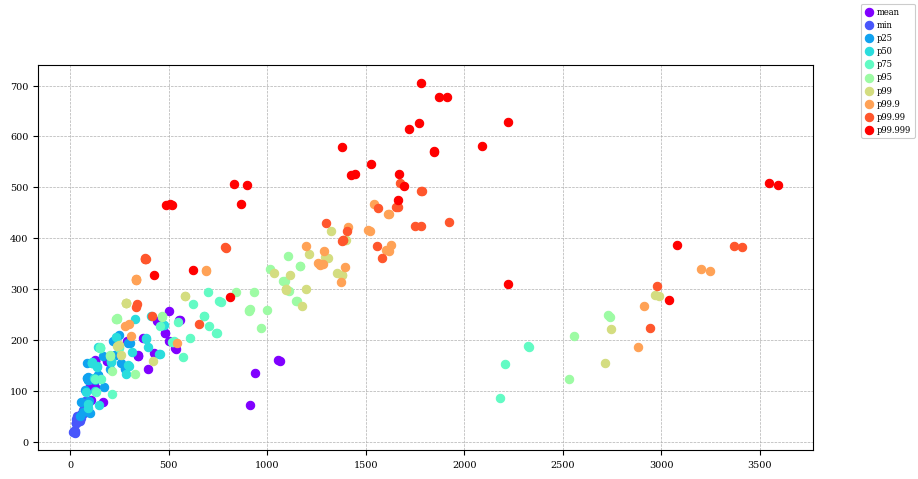

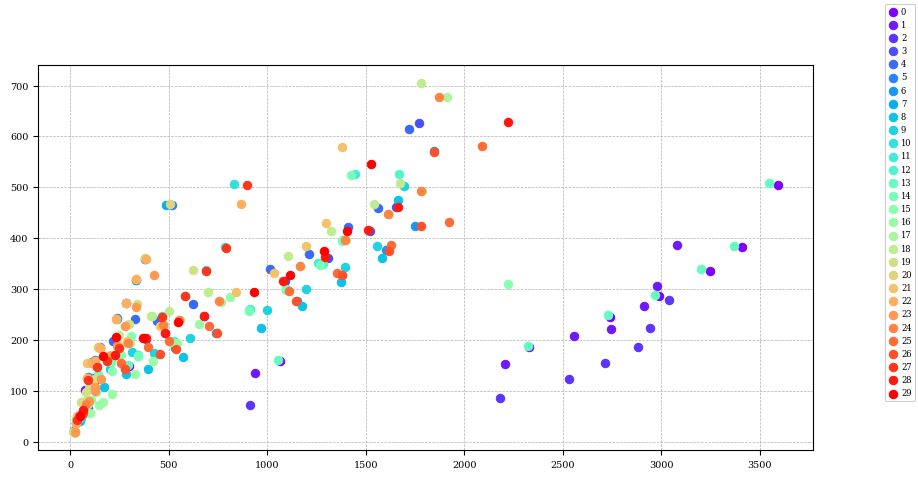

In [16]:
TOPO_NUM = 4
topo_data = df_rel_errs[df_rel_errs.topo_num == TOPO_NUM]

# Scatter plot for targets
fig, axes = scatter_topo(topo_data)
fig.legend()

# Scatter plot for flows
fig, axes = scatter_flow(topo_data)
fig.legend()

In [17]:
def scatter_targets(data, fig=None, axes=None):
    #targets = ['min'] + [f'p{i}' for i in range(20, 90, 20)] + ['p99', 'p99.9', 'p99.99']
    target_dict = {
        'min': 'min',
        'p25': '$\\mathregular{p_{25}}$',
        'p50': '$\\mathregular{p_{50}}$',
        'p75': '$\\mathregular{p_{75}}$',
        #'p95': '$\\mathregular{p_{95}}$',
        'p99': '$\\mathregular{p_{99}}$',
        'p99.9': '$\\mathregular{p_{99.9}}$',
        'p99.99': '$\\mathregular{p_{99.99}}$',
        'p99.999': '$\\mathregular{p_{99.999}}$'
    }
    targets = list(target_dict.keys())
    colors = cm.coolwarm(np.linspace(0, 1, len(targets)))
    markers = ['o', '^', 's', 'P', '*', 'p', 'D', 'v']

    if fig is None:
        figsize = set_size('single')
        fig, axes = plt.subplots(1, 1, figsize=(figsize[0], figsize[1] * .8))
    for i, target in enumerate(targets):
        d = data[data.target == target]
        axes.scatter(d.label, d.prediction, color=colors[i], label=target_dict[target], marker=markers[i % len(markers)])
    _ = axes.set_xlabel('Latency [$\\mu$s]')
    _ = axes.set_ylabel('Predicted [$\\mu$s]')
    return fig, axes

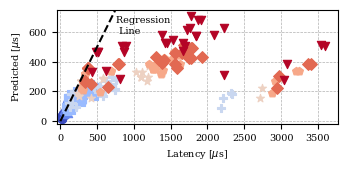

In [18]:
TOPO_NUM = 4
topo_data = df_rel_errs[df_rel_errs.topo_num == TOPO_NUM]

fig, axes = scatter_targets(topo_data)
axes.set_ylim(ymax=750)
axes.set_xlim((-50, None))
axes.plot([0, 850], [0, 850], color='black', linestyle='--')
axes.text(750, 590, 'Regression \n Line')
#fig.legend(bbox_to_anchor=(.94, .62), loc='center left', ncols=1)

fig.tight_layout()
save_plot(fig, f'scatter-topo-{TOPO_NUM}.pdf')

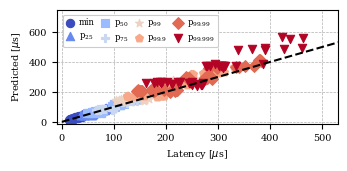

In [19]:
TOPO_NUM = 0
topo_data = df_rel_errs[df_rel_errs.topo_num == TOPO_NUM]

fig, axes = scatter_targets(topo_data)
axes.set_ylim(ymax=750)
axes.set_xlim((-10, 530))
axes.plot([0, 650], [0, 650], color='black', linestyle='--')
#axes.text(530, 400, 'Regression \n Line')
fig.legend(bbox_to_anchor=(0.17, .815), loc='center left', ncols=4)

fig.tight_layout()
save_plot(fig, f'scatter-topo-{TOPO_NUM}.pdf')

In [20]:
def scatter_flows(data):    
    figsize = set_size('single')
    fig, axes = plt.subplots(1, 1, figsize=(figsize[0] * .5, figsize[0] * .5))
    axes.scatter(data.label, data.prediction)
    _ = axes.set_xlabel('Latency [$\\mu$s]')
    _ = axes.set_ylabel('Predicted [$\\mu$s]')
    return fig, axes

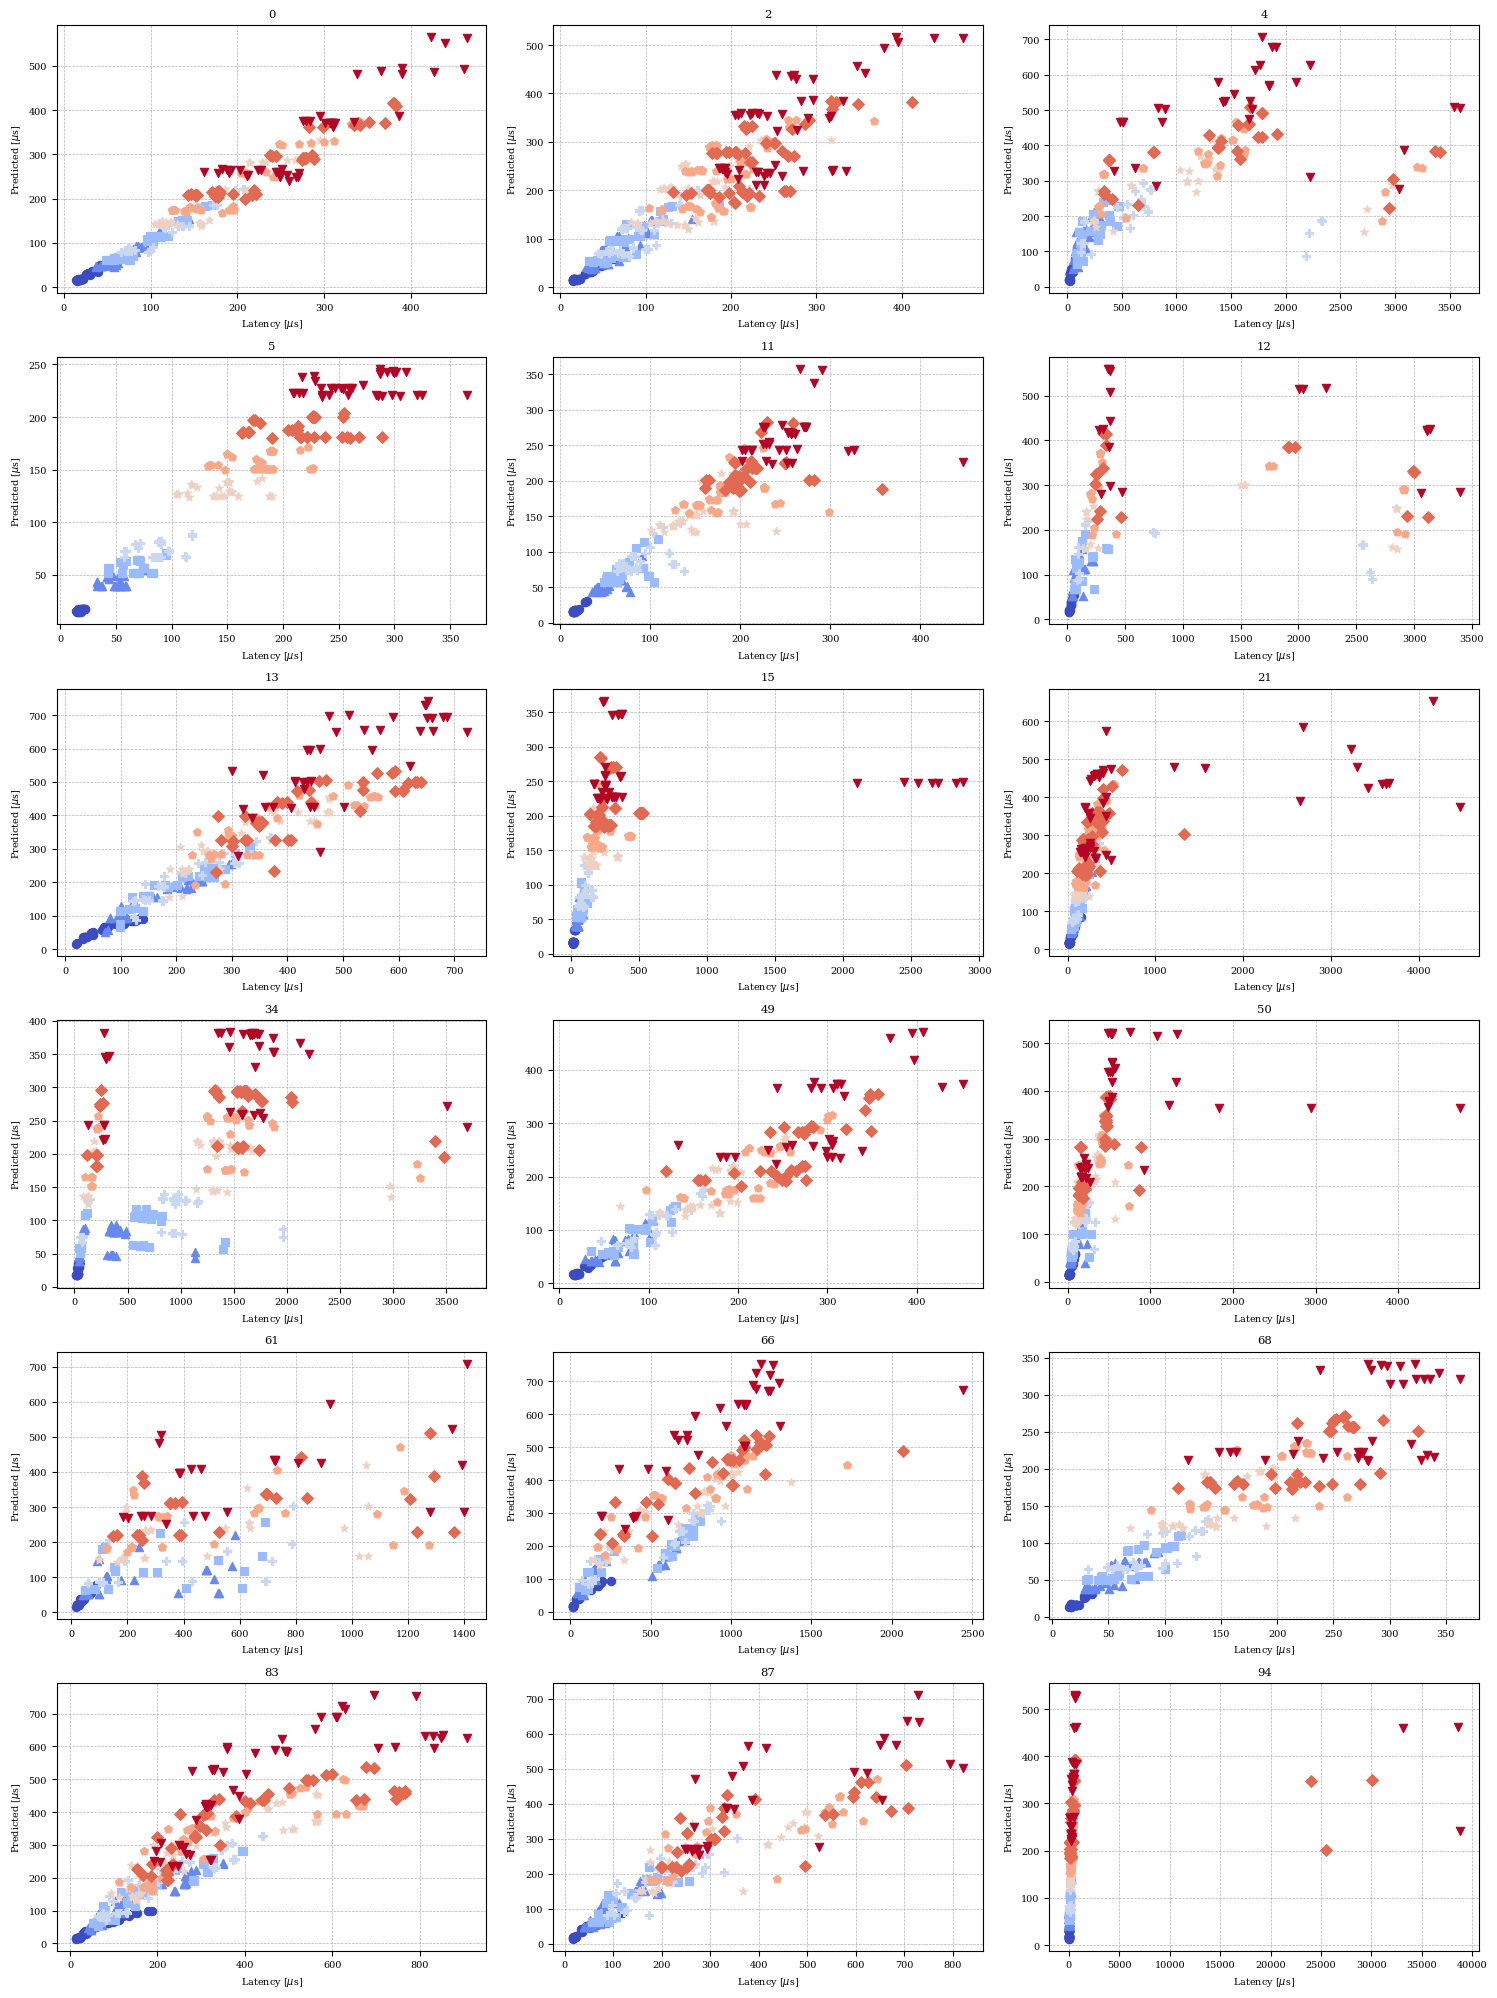

In [21]:
topos = sorted(df_rel_errs.topo_num.unique())

fig = plt.figure(figsize=(15, 20))

for i, topo in enumerate(topos, 1):
    topo_data = df_rel_errs[df_rel_errs.topo_num == topo]
    axes = fig.add_subplot(6, 3, i)
    _, _ = scatter_targets(topo_data, fig=fig, axes=axes)
    axes.set_title(f'{topo}')
fig.tight_layout()
save_plot(fig, 'scatter-all.pdf')

In [22]:
def plot_cdf(data, fig=None, axes=None):
    target_dict = {
        'min': 'min',
        'p25': '$\\mathregular{p_{25}}$',
        'p50': '$\\mathregular{p_{50}}$',
        'p75': '$\\mathregular{p_{75}}$',
        'p99': '$\\mathregular{p_{99}}$',
        'p99.9': '$\\mathregular{p_{99.9}}$',
        'p99.99': '$\\mathregular{p_{99.99}}$',
        'p99.999': '$\\mathregular{p_{99.999}}$'
    }
    targets = list(target_dict.keys())
    colors = cm.coolwarm(np.linspace(0, 1, len(targets)))
    markers = ['o', '^', 's', 'P', '*', 'p', 'D', 'v']

    if fig is None:
        fig, axes = plt.subplots()
    for i, target in enumerate(targets):
        d = data[data.target == target]
        #axes.scatter(d.label, d.prediction, color=colors[i], label=target_dict[target], marker=markers[i % len(markers)])
        axes.hist(d.rel_err, bins=len(d.index), color=colors[i], density=True, cumulative=True, label=target_dict[target], histtype='step')
    axes.set_xlabel('Relative Error')
    axes.set_ylabel('CDF')
    return fig, axes

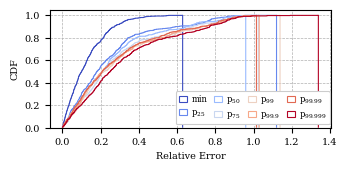

In [23]:
fig, axes = plot_cdf(df_rel_errs)
#axes.set_xlim(-1000, 5000)
fig.set_size_inches(set_size('single')[0], set_size('single')[1] * .8)
fig.tight_layout()
fig.legend(bbox_to_anchor=(.96, .25), loc='lower right', ncols=4)
save_plot(fig, 'mape_cdf.pdf')

In [24]:
df_rel_errs[df_rel_errs.rel_err > 1]

,topo_num,flow_num,target,label,prediction,rel_err
259,94,7,p99,72.063000,149.089660,1.068879
261,94,9,p99,73.374740,149.596280,1.038798
284,94,32,p99,72.193500,149.269990,1.067638
287,94,35,p99,71.787890,148.892620,1.074063
301,94,7,p99.9,89.722370,181.660400,1.024695
326,94,32,p99.9,89.588950,181.830060,1.029604
329,94,35,p99.9,90.389450,181.437320,1.007284
343,94,7,p99.99,107.947690,217.399370,1.013932
368,94,32,p99.99,107.969560,217.594740,1.015334
385,94,7,p99.999,129.785060,269.310330,1.075049


In [25]:
def plot_total_cdf(data, fig=None, axes=None):
    if fig is None:
        figsize = set_size('single')
        fig, axes = plt.subplots(1, 1, figsize=(figsize[0], figsize[1] * .8))
        #axes.scatter(d.label, d.prediction, color=colors[i], label=target_dict[target], marker=markers[i % len(markers)])
    axes.hist(data.rel_err, bins=len(d.index), density=True, cumulative=True, histtype='step')
    _ = axes.set_xlabel('MAPE')
    _ = axes.set_ylabel('CDF')
    return fig, axes

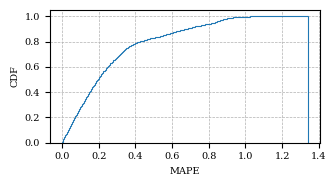

In [26]:
fig, axes = plot_total_cdf(df_rel_errs)

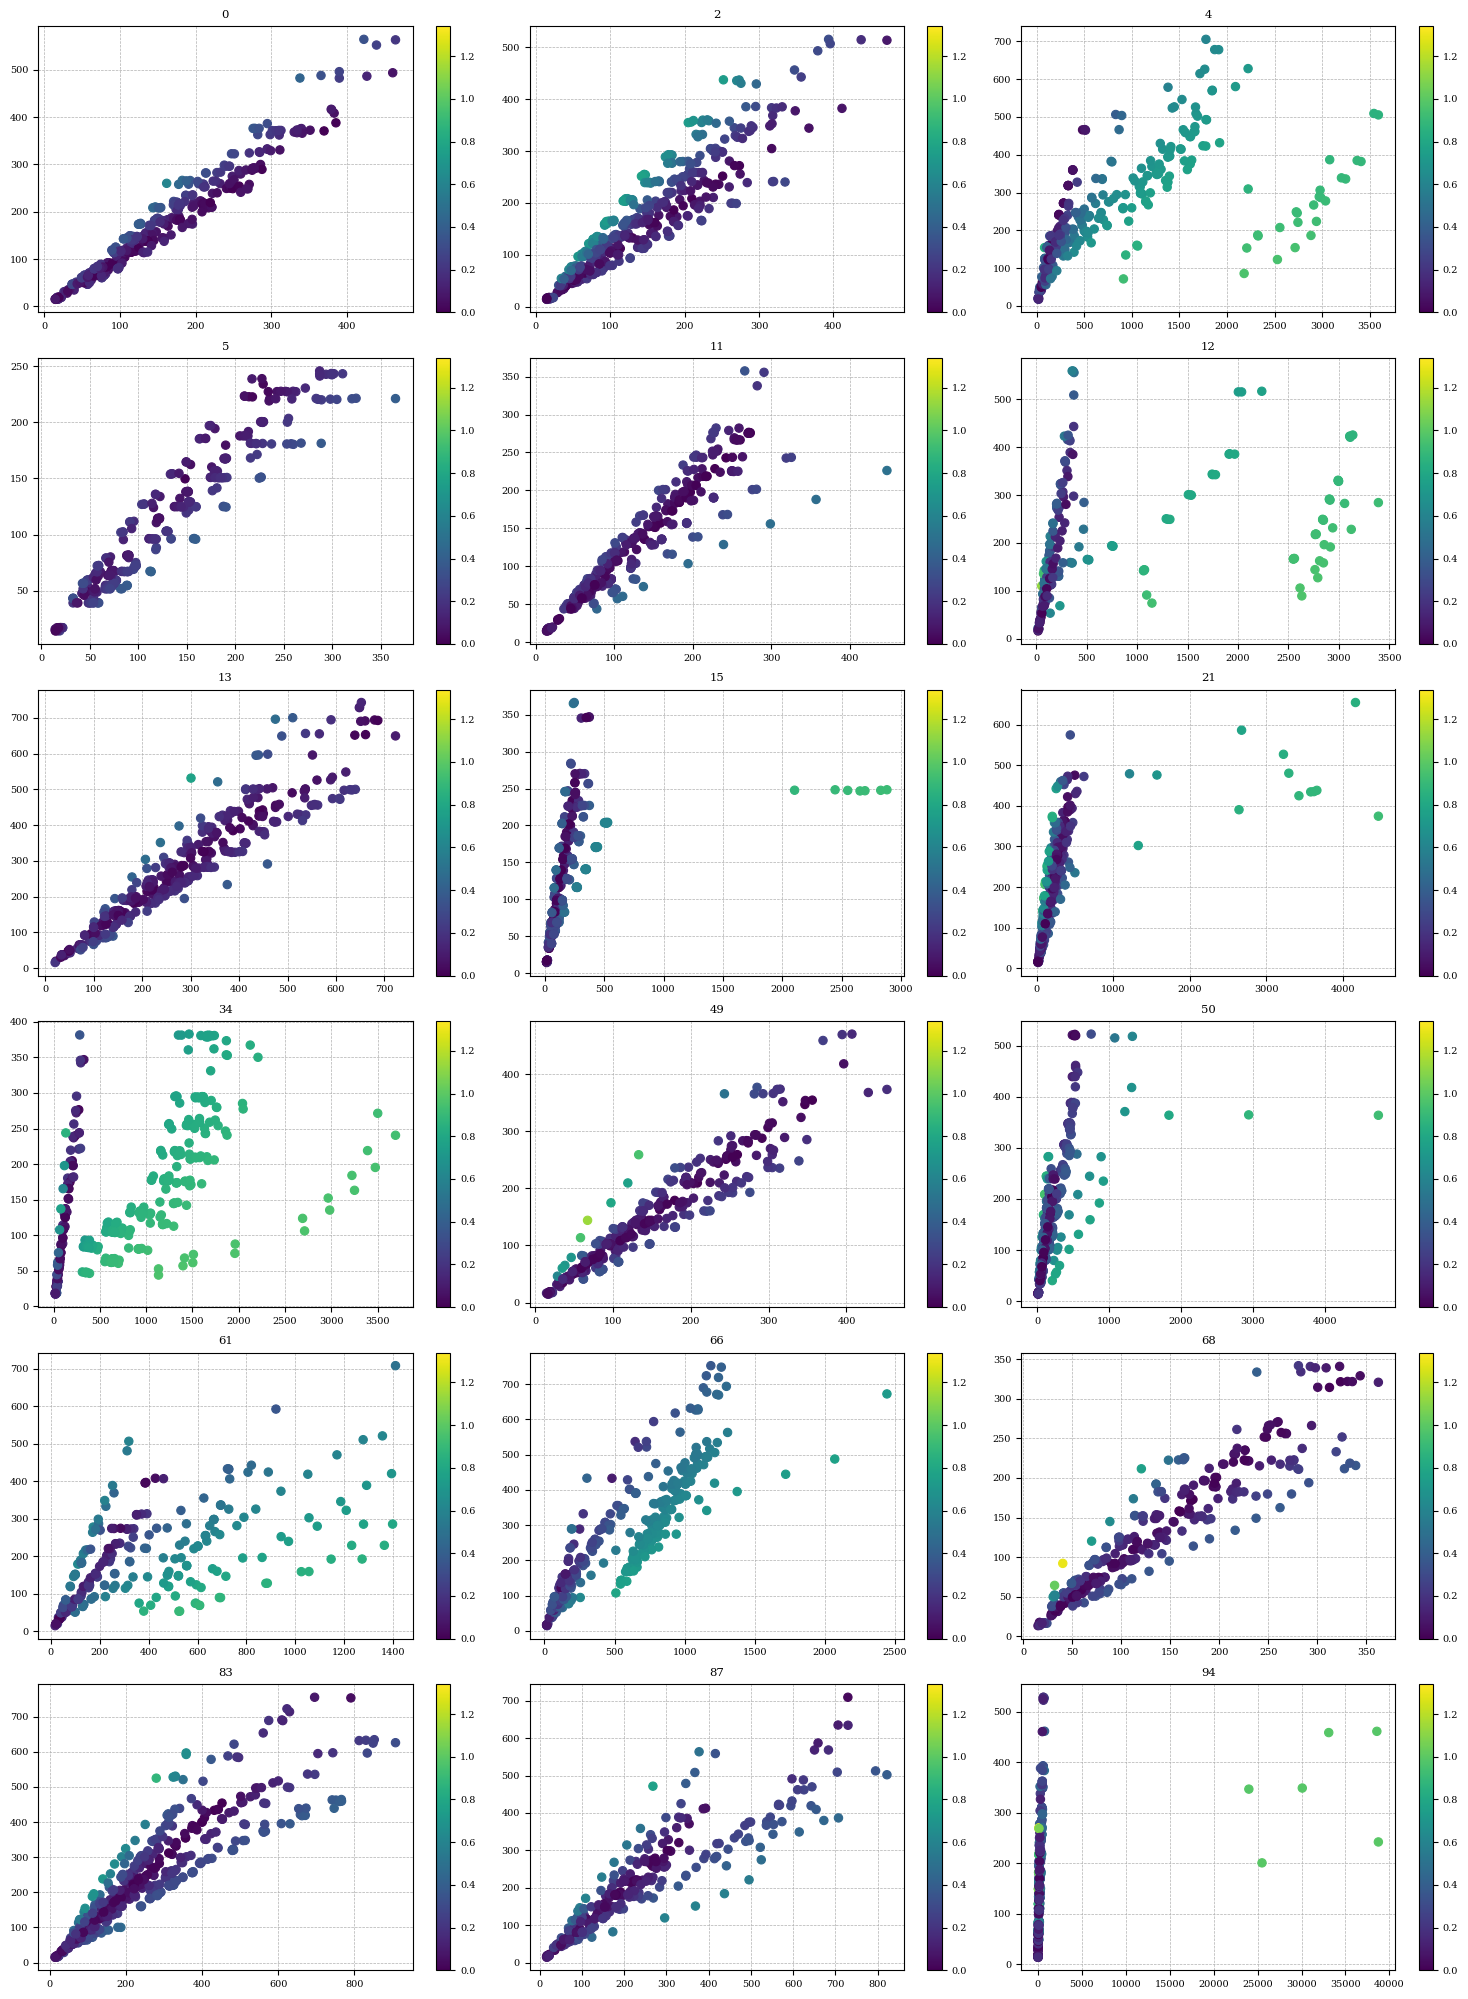

In [27]:
topos = sorted(df_rel_errs.topo_num.unique())

fig = plt.figure(figsize=(15, 20))

for i, topo in enumerate(topos, 1):
    topo_data = df_rel_errs[df_rel_errs.topo_num == topo]
    axes = fig.add_subplot(6, 3, i)
    s = axes.scatter(topo_data.label, topo_data.prediction, c=topo_data.rel_err,
                     vmin=0, vmax=df_rel_errs.rel_err.max())
    
    axes.set_title(f'{topo}')
    cbar = fig.colorbar(s, ax=axes)

    #d2 = topo_data[(.4 < topo_data.rel_err) & (topo_data.rel_err < .7)]
    #axes.scatter(d2.label, d2.prediction, color='red')

    #fig.colorbar(ax=axes)
fig.tight_layout()
#save_plot(fig, 'scatter-color.pdf')